In [1]:
# 画像の前処理に必要なライブラリ
!pip install numpy scipy scikit-image matplotlibimport numpy as np # linear algebra

ERROR: Could not find a version that satisfies the requirement matplotlibimport (from versions: none)
ERROR: No matching distribution found for matplotlibimport


In [2]:
# tritonはpythonライクな言語らしい
!pip install --pre -U triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 8.2 MB/s eta 0:00:00:00:0100:01


In [3]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch

# COCOデータセットに対する学習済みモデルをダウンロード (公式そのものでおまじない)
precision = 'fp32'
# COCOデータセットの学習済みモデル
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
# 入出力フォーマット整形のユーティリティ
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

/opt/conda/lib/python3.10/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [4]:
import os
os.chdir('/kaggle/input/warabidon/dataset2')

In [5]:
# パッケージのimport
import os.path as osp
import os
import sys
import random
import time
import glob
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
from utils.ssd_model import VOCDataset, DataTransform, Anno_xml2list, od_collate_fn
from utils.ssd_model import SSD
from utils.ssd_model import MultiBoxLoss

In [21]:
# データのリストを取得
# 共通のデータパス
data_path = '/kaggle/input/warabidon/dataset2/od_warabi'
# ファイルリスト取得
filename_list = [os.path.split(f)[1].split('.')[0] for f in glob.glob(f'{data_path}/*.xml')]
# 全画像ファイルを訓練データと評価データに分ける
filename_list_train, filename_list_val = train_test_split(filename_list, test_size=0.1)
# jpgとxmlに分ける
train_img_list = [f'{data_path}/{f}.jpeg' for f in filename_list_train]
train_anno_list = [f'{data_path}/{f}.xml' for f in filename_list_train]
val_img_list = [f'{data_path}/{f}.jpeg' for f in filename_list_val]
val_anno_list = [f'{data_path}/{f}.xml' for f in filename_list_val]
# Datasetを作成
voc_classes = ['warabi']
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズ
train_dataset = VOCDataset(train_img_list, 
                           train_anno_list, 
                           phase="train", 
                           transform=DataTransform(input_size, color_mean), 
                           transform_anno=Anno_xml2list(voc_classes))
val_dataset = VOCDataset(val_img_list, 
                         val_anno_list, 
                         phase="val", 
                         transform=DataTransform(input_size, color_mean), 
                         transform_anno=Anno_xml2list(voc_classes))
# DataLoaderを作成する
train_dataloader = data.DataLoader(train_dataset, 
                                   batch_size=32, 
                                   shuffle=True, 
                                   collate_fn=od_collate_fn)
val_dataloader = data.DataLoader(val_dataset, 
                                 batch_size=3, 
                                 shuffle=False, 
                                 collate_fn=od_collate_fn)
# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [20]:
# import glob
# # 検出する画像リスト
# img_files = glob.glob('/kaggle/input/warabidon/dataset2/od_warabi/*.jpg')

# # 2枚だけ抽出
# uris = [
#     img_files[0],
#     img_files[1],
# ]

IndexError: list index out of range

In [22]:
# SSD300の設定
ssd_cfg = {
    'num_classes': 2,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [21, 45, 99, 153, 207, 261],  # DBOXの大きさを決める
    'max_sizes': [45, 99, 153, 207, 261, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}
# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

In [23]:
# SSDの初期の重みを設定
vgg_weights = torch.load('/kaggle/input/warabidon/dataset2/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

/tmp/ipykernel_36/2858076424.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_weights = torch.load('/kaggle/input/warabidon/dataset2/vgg16_reducedfc.pth')


<All keys matched successfully>

In [24]:
# ssdのその他のネットワークの重みはHeの初期値で初期化
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)
        
# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)
# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)
print('ネットワーク設定完了：学習済みの重みをロードしました')

使用デバイス： cuda:0
ネットワーク設定完了：学習済みの重みをロードしました


In [25]:
# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)
# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [26]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    # ネットワークをGPUへ
    net.to(device)
    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    min_loss = 9999
    logs = []
    
    # epochのループ
    for epoch in range(num_epochs+1):
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        
        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            # データローダーからminibatchずつ取り出すループ
            with tqdm(dataloaders_dict[phase], desc=phase, file=sys.stdout) as iterator:
                for images, targets in iterator:
                    # GPUが使えるならGPUにデータを送る
                    images = images.to(device)
                    targets = [ann.to(device)
                               for ann in targets]  # リストの各要素のテンソルをGPUへ
                    # optimizerを初期化
                    optimizer.zero_grad()
                    # 順伝搬（forward）計算
                    with torch.set_grad_enabled(phase == 'train'):
                        # 順伝搬（forward）計算
                        outputs = net(images)
                        # 損失の計算
                        loss_l, loss_c = criterion(outputs, targets)
                        loss = loss_l + loss_c
                        
                        # 訓練時はバックプロパゲーション
                        if phase == 'train':
                            loss.backward()
                            nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                            optimizer.step()
                            epoch_train_loss += loss.item()
                            iteration += 1
                        # 検証時
                        else:
                            epoch_val_loss += loss.item()
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print(f'epoch {epoch+1}/{num_epochs} {(t_epoch_finish - t_epoch_start):.4f}sec || train_Loss:{epoch_train_loss:.4f} val_Loss:{epoch_val_loss:.4f}')
        t_epoch_start = time.time()
        # vallossが小さい、ネットワークを保存する
        if min_loss>epoch_val_loss:
            min_loss=epoch_val_loss
            torch.save(net.state_dict(), 'ssd_best.pth')
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

In [27]:
os.chdir('/kaggle/working/')

In [28]:
# 学習・検証を実行する
num_epochs= 200
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
val: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
epoch 1/200 34.4358sec || train_Loss:17.8448 val_Loss:16.1242
val: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]
epoch 2/200 1.1056sec || train_Loss:14.6850 val_Loss:10.9739
val: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]
epoch 3/200 1.0615sec || train_Loss:9.9159 val_Loss:7.9847
val: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]
epoch 4/200 1.0566sec || train_Loss:8.1936 val_Loss:7.0291
val: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]
epoch 5/200 1.0757sec || train_Loss:7.8511 val_Loss:6.2584
val: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]
epoch 6/200 1.0417sec || train_Loss:6.5634 val_Loss:5.9955
val: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]
epoch 7/200 1.0502sec || train_Loss:6.4357 val_Loss:5.7755
val: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]
epoch 8/200 1.0557sec || train_Loss:6.2922 val_Loss:5.7924
val: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]
epoch 9/200 1.0567sec || train_Loss:5.8774 val_Lo

In [29]:
from utils.ssd_model import SSD
from utils.ssd_model import DataTransform
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch
from utils.ssd_predict_show import SSDPredictShow

In [30]:
voc_classes = ['warabi']
# SSDネットワークモデル
ssd_cfg = {
    'num_classes': 2,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [21, 45, 99, 153, 207, 261],  # DBOXの大きさを決める
    'max_sizes': [45, 99, 153, 207, 261, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}
net = SSD(phase="inference", cfg=ssd_cfg)
# SSDの学習済みの重みを設定
net_weights = torch.load('/kaggle/working/ssd_best.pth', map_location={'cuda:0': 'cpu'})
net.load_state_dict(net_weights)
print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


/tmp/ipykernel_36/2258529665.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_weights = torch.load('/kaggle/working/ssd_best.pth', map_location={'cuda:0': 'cpu'})


/kaggle/input/warabidon/dataset2/utils/ssd_model.py:590: UserWarning: An output with one or more elements was resized since it had shape [103], which does not match the required output shape [65]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Resize.cpp:28.)
  torch.index_select(x1, 0, idx, out=tmp_x1)
/kaggle/input/warabidon/dataset2/utils/ssd_model.py:591: UserWarning: An output with one or more elements was resized since it had shape [103], which does not match the required output shape [65]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /usr/

box [104.39664349  20.82526168 212.72439063 183.09718716]
label warabi
score 0.9736838


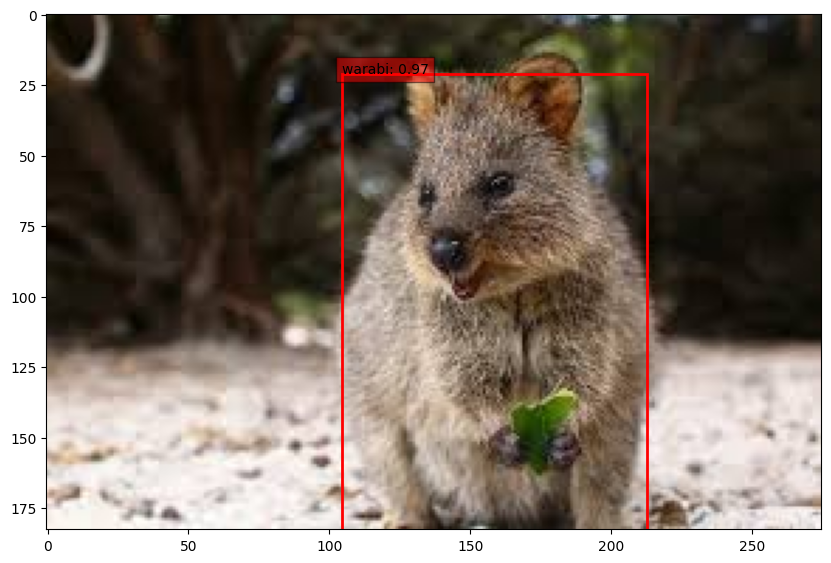

In [35]:
# ファイルパス
image_file_path = "/kaggle/input/warabidon/dataset2/od_warabi/6.jpeg"
# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.5)
# ボックスなどを取得
rgb_img, predict_bbox, pre_dict_label_index, scores = ssd.ssd_predict(image_file_path)
for i in range(len(predict_bbox)):
    print('box', predict_bbox[i])
    print('label', voc_classes[pre_dict_label_index[i]])
    print('score', scores[i])

In [1]:
print("end")

end
